In [ ]:
# The wavelet coeeficient I plotted, shows the captured details of the signal 
# at different scales.
# The lmax is different, increase nside, gets subdivide the sphere into more
# pixels, and the lmax is increased.
# number of pixels  

# Can you increase lmax and plot the wv coefficients for the same signal at the scale,
# yes, but you will hacve to add zeros, becuase there is no details
# to make the picture clear.

# We use wavelet to filter out a lot of large amplitude fluctuations, and small scale of details
# and the small scale of details are noise

In [4]:
import jax
jax.config.update("jax_enable_x64", True)
# import s2fft
import healpy as hp
import numpy as np
# import s2wav
# import s2wav.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline 


# # Step 1: Read the Healpix map
# CMB_map_path = 'data/planck_simulation/ffp10_newdust_total_030_full_map.fits'
# original_healpix_map = hp.read_map(CMB_map_path)



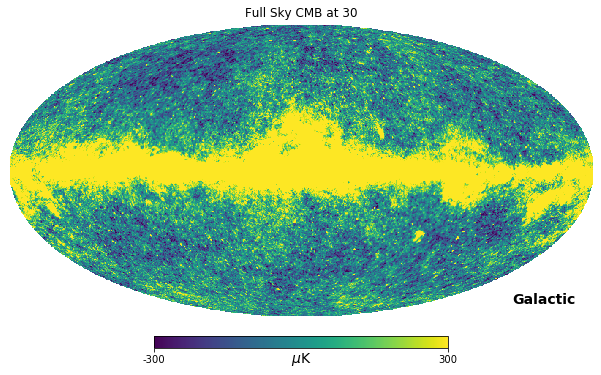

In [4]:
frequency = "30"
hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="Full Sky CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )


In [2]:
# Step 2: Convert Healpix map to spherical harmonic coefficients
# convention: L_max = nside * 2
nside = hp.get_nside(original_healpix_map)
L_max = nside*2  # Define maximum multipole moment / detail level
alm = hp.map2alm(original_healpix_map, lmax=L_max-1)
# lmax = L_max - 1 because python is 0-indexed

In [3]:
# Step 3: Rearrange coefficients for s2wav: from 1 dimensional to 2 dimensional
# s2fft only works with alm in 2d
alm_2d = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

for l in range(L_max):
    for m in range(-l, l + 1):
        index = hp.Alm.getidx(L_max - 1, l, abs(m))
        if m < 0:
            alm_2d[l, L_max + m - 1] = (-1)**m * np.conj(alm[index])
        else:
            alm_2d[l, L_max + m - 1] = alm[index]
print(f"Shape of alm_2d: {alm_2d.shape}")

Shape of alm_2d: (2048, 4095)


In [4]:
# Step 4: Apply s2fft to the 2d alm to get the map in MW sampling (2d)
# original_MW_Map = s2fft.inverse(alm_2d, L_max)
# np.save('data/original_MW_map.npy', original_MW_Map)
stored_original_MW_map = np.load('data/original_MW_map.npy')

In [5]:
# Step 5: Apply s2wav to the MW map to get the wavelet and scaling coefficients
N_directions = 1  # Number of directional wavelets
filter = filters.filters_directional_vectorised(L_max, N_directions)

# wavelet_coeffs, scaling_coeffs = s2wav.analysis(stored_original_MW_map, L_max, N_directions, filters=filter,reality = False)

# # Convert each element in f_wav to a numpy array and save it
# for i, wav in enumerate(wavelet_coeffs):
#     np_wav = np.array(wav)  # Convert JAX array to numpy array
#     np.save(f"convolution/wavelet_coefficient/wav_30_{i}", np_wav)  

# # Convert  f_scal to a numpy array and save it
# np_scal = np.array(scaling_coeffs)  # Convert JAX array to numpy array
# np.save(f"convolution/scaling_coefficient/scal_30", np_scal)  
stored_wavelet_coeffs = [np.load(f"convolution/wavelet_coefficient/wav_30_{i}.npy", allow_pickle=True) for i in range(12)]
stored_scaling_coeffs = np.load("convolution/scaling_coefficient/scal_30.npy")


In [7]:
print(filter[0].shape)
print(filter[1].shape)

(12, 2048, 4095)
(2048,)


In [28]:
# Stored_original_MW_map = np.load('data/MW_Map.npy')
# # is_real = np.isreal(original_healpix_map)
# is_real = np.isreal(Stored_original_MW_map)
# print(is_real.all()) 
#  setting reality=True in the context of spherical harmonic analysis indicates that the input data is real-valued, and the function leverages the conjugate symmetry property of the harmonic coefficients to optimize storage and computation.

False


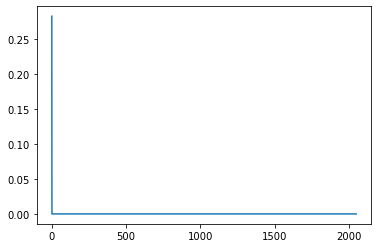

In [8]:
plt.plot(filter[1])
# plt.plot(stored_wavelet_coeffs[1])

In [8]:
# reconstructed_MW_map_raw = s2wav.synthesis(stored_wavelet_coeffs, stored_scaling_coeffs, L_max, N_directions, filters=filter, reality = False)

# reconstructed_MW_map = np.array(reconstructed_MW_map_raw)
# np.save(f"convolution/reconstructed_MW_map", reconstructed_MW_map)  # Save numpy array to a file
stored_reconstructed_MW_map = np.load("convolution/reconstructed_MW_map.npy")


In [ ]:
# print(f"Mean absolute error = {np.nanmean(np.abs(reconstructed_MW_map_raw - original_MW_Map))}")

In [10]:
print(f"Mean absolute error = {np.nanmean(np.abs(stored_reconstructed_MW_map - stored_original_MW_map))}")

Mean absolute error = 5.027191403597514e-15


In [11]:

# Step 2: Perform spherical harmonic transform using s2fft
# alm_reconstructed_MW_map = s2fft.forward(stored_reconstructed_MW_map, L_max)
# np.save('data/alm_reconstructed_MW_map.npy', alm_reconstructed_MW_map)
stored_alm_reconstructed_MW_map = np.load('data/alm_reconstructed_MW_map.npy')

In [13]:
# Step 3: Rearrange coefficients for healpy
# n_coeff = hp.Alm.getsize(L_max-1)
# reconstructed_healpix_alm = np.zeros(n_coeff, dtype=np.complex128)

# for l in range(L_max):
#     for m in range(-l, l + 1):
#         alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
#         if alm_index >= n_coeff:
#             print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
#             continue
#         if m < 0:
#             reconstructed_healpix_alm[alm_index] = (-1) ** m * np.conj(stored_alm_reconstructed_MW_map[l, L_max + m - 1])
#         else:
#             reconstructed_healpix_alm[alm_index] = stored_alm_reconstructed_MW_map[l, L_max + m - 1]


In [12]:
# Now `alm` is ready to be used with healpy
nside = L_max // 2
# healpix_map = hp.alm2map(reconstructed_healpix_alm, nside, verbose=False)

# Save the HEALPix map to a FITS file
output_fits_path = 'reconstructed_healpix_map.fits'
# hp.write_map(output_fits_path, healpix_map, overwrite=True, dtype=np.float64)

In [13]:
new_healpix_map = hp.read_map(output_fits_path)

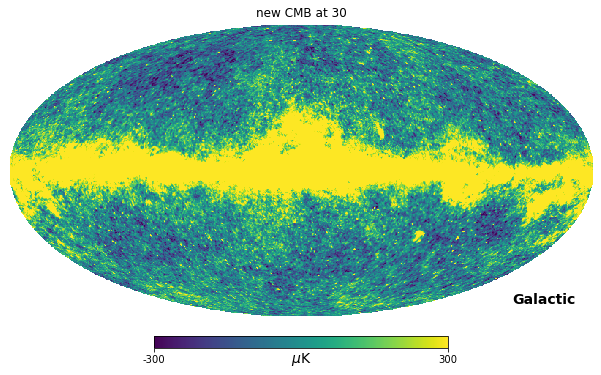

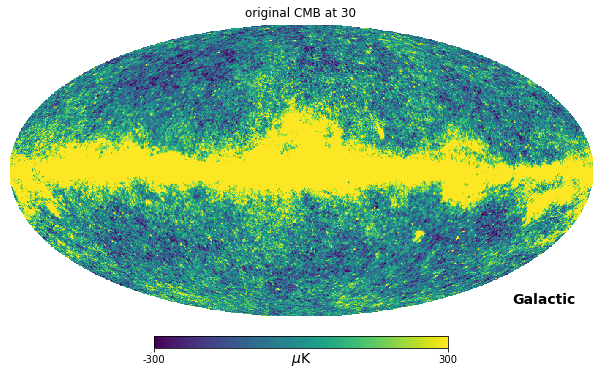

In [14]:
frequency = "30"
hp.mollview(
        new_healpix_map*1e6,
        coord=["G"],
        title="new CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )
frequency = "30"
hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="original CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )

In [18]:
print(len(stored_wavelet_coeffs))

12


In [6]:
for i in range(len(stored_wavelet_coeffs)):
    print(f"Shape of wavelet_coeffs:{i} {stored_wavelet_coeffs[i].shape}")
# print(f"Shape of wavelet_coeffs: {stored_wavelet_coeffs[1].shape}")

Shape of wavelet_coeffs:0 (1, 4, 7)
Shape of wavelet_coeffs:1 (1, 4, 7)
Shape of wavelet_coeffs:2 (1, 8, 15)
Shape of wavelet_coeffs:3 (1, 16, 31)
Shape of wavelet_coeffs:4 (1, 32, 63)
Shape of wavelet_coeffs:5 (1, 64, 127)
Shape of wavelet_coeffs:6 (1, 128, 255)
Shape of wavelet_coeffs:7 (1, 256, 511)
Shape of wavelet_coeffs:8 (1, 512, 1023)
Shape of wavelet_coeffs:9 (1, 1024, 2047)
Shape of wavelet_coeffs:10 (1, 2048, 4095)
Shape of wavelet_coeffs:11 (1, 2048, 4095)


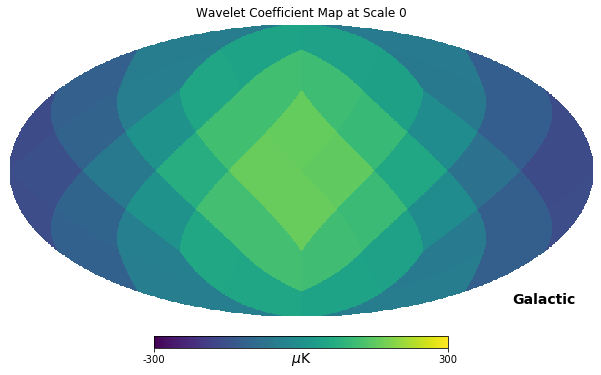

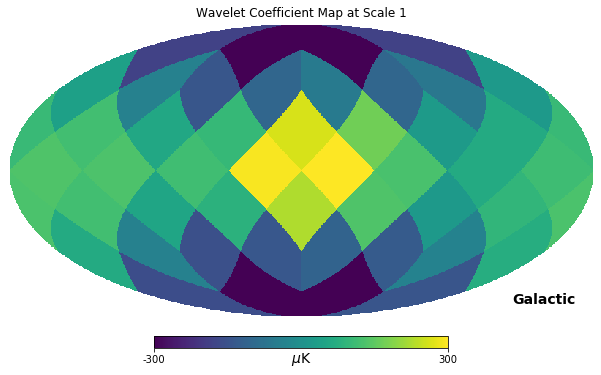

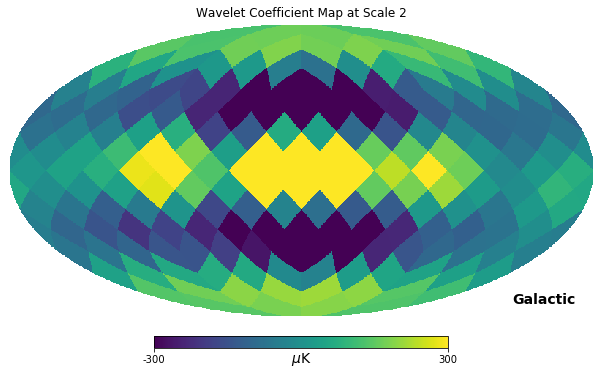

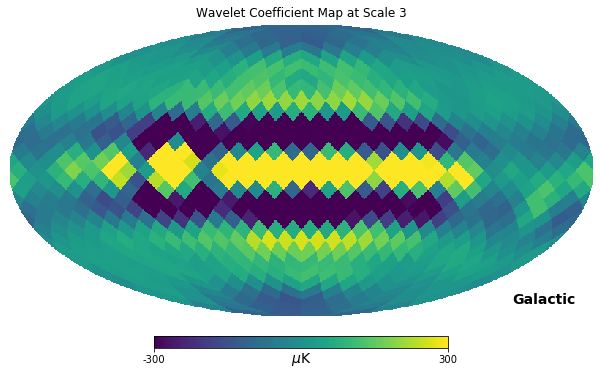

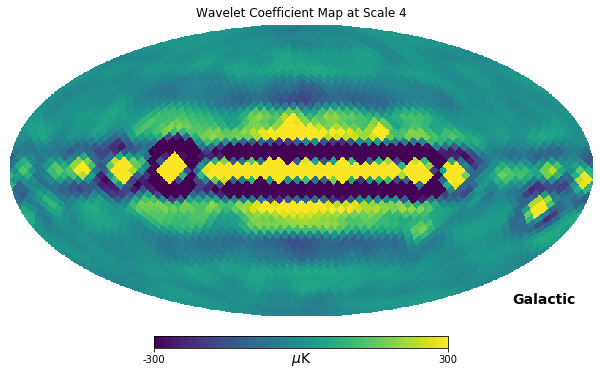

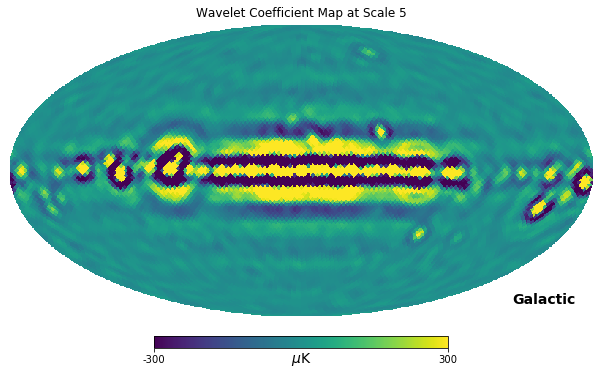

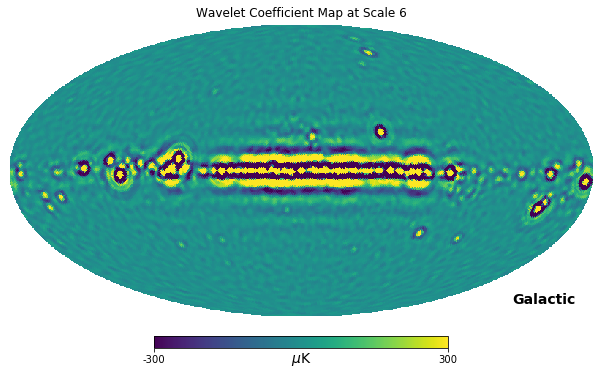

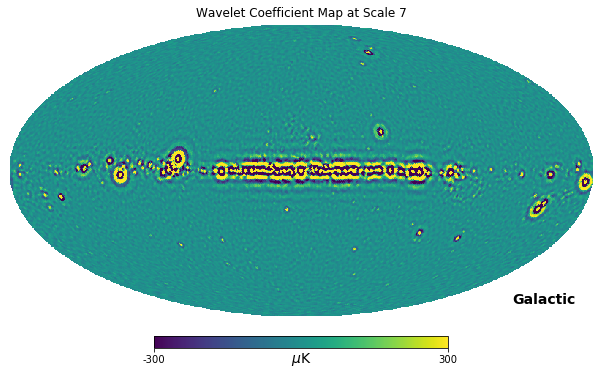

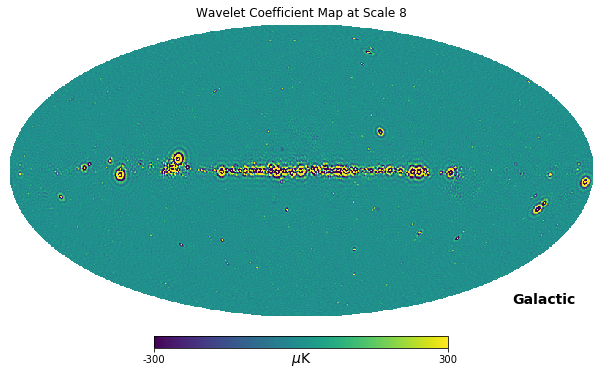

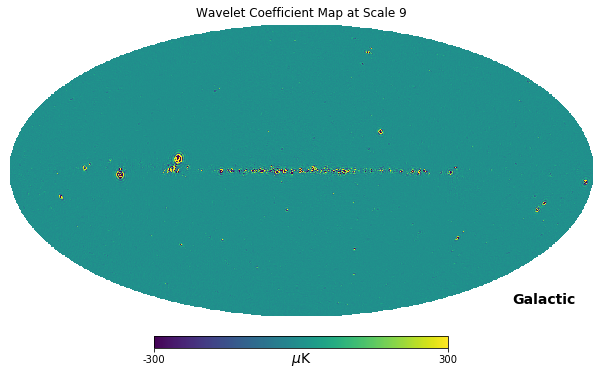

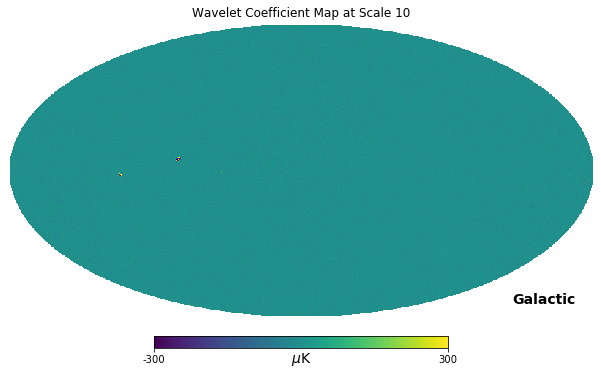

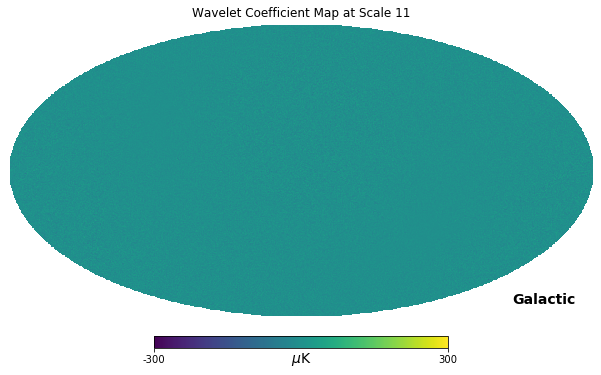

In [8]:
for i in range(12):
    # perform a forward transformation to convert 
    # the wavelet coefficients into the spherical harmonic alm space (2D).

    wavelet_in_alm = s2fft.forward(stored_wavelet_coeffs[i], L = stored_wavelet_coeffs[i].shape[1])
    alm_reconstructed_MW_map = wavelet_in_alm 
    L_max = stored_wavelet_coeffs[i].shape[1]
    np.save(f"convolution/alm_reconstructed_MW_map_{i}", alm_reconstructed_MW_map)  # Save numpy array to a file
    
    #Rearrange coefficients for healpy (1D).
    n_coeff = hp.Alm.getsize(L_max-1)
    reconstructed_healpix_alm_1 = np.zeros(n_coeff, dtype=np.complex128)
    
    for l in range(L_max):
        for m in range(-l, l + 1):
            alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if alm_index >= n_coeff:
                print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
                continue
            if m < 0:
                reconstructed_healpix_alm_1[alm_index] = (-1) ** m * np.conj(alm_reconstructed_MW_map[l, L_max + m - 1])
            else:
                reconstructed_healpix_alm_1[alm_index] = alm_reconstructed_MW_map[l, L_max + m - 1]
    
    # Use the alm2map function to convert them into a Healpix map.
    nside = L_max // 2
    wavelet_healpix_map = hp.alm2map(reconstructed_healpix_alm_1, nside, verbose=False)
    np.save(f"convolution/wavelet_healpix_map_{i}",wavelet_healpix_map)  # Save numpy array to a file
    wavelet_scale = str(i)
    
    # Use hp.mollview to plot the wavelet coefficient map.

    hp.mollview(
            wavelet_healpix_map*1e6,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale "+wavelet_scale,
            unit=r"$\mu$K",
            min=-300, 
            max=300,
        )



In [12]:
alm_reconstructed_MW_map = np.load(f"convolution/alm_reconstructed_MW_map_{1}.npy")


(4, 7)

In [4]:
import numpy as np
import healpy as hp

/tmp/ipykernel_112650/2522046003.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


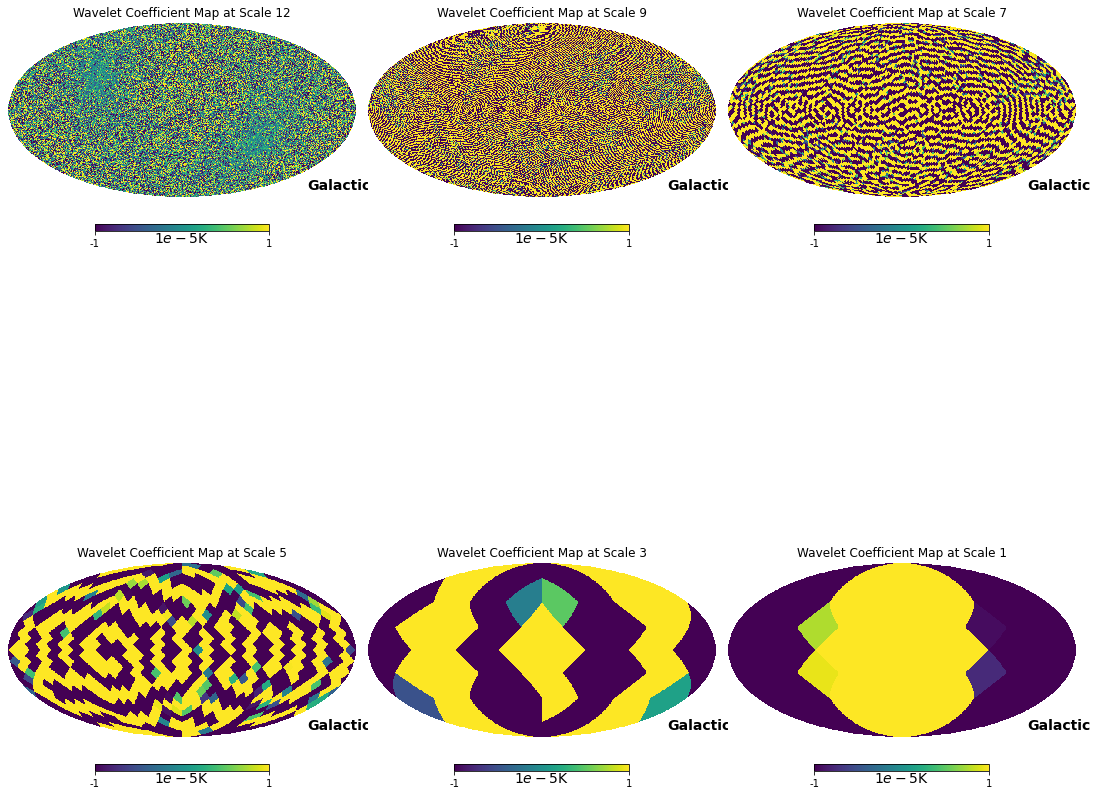

In [23]:


# Create a figure with a 3x3 grid of subplots
fig = plt.figure(figsize=(15, 15))
[0, 2, 4, 6, 8, 11]
# n = 1
# Iterate over frequencies and corresponding axes
for i, frequency in enumerate([11, 8, 6, 4, 2, 0]):

    wavelet_healpix_map = np.load(f"/home/max/CMB_plot/convolution/wavelet_healpix_map_{frequency}.npy")
    wavelet_scale = str(frequency+1)
    
    hp.mollview(
        wavelet_healpix_map * 1e5,
        coord=["G"],
        title="Wavelet Coefficient Map at Scale " + wavelet_scale,
        unit=r"$1e-5$K",
        min=-1,
        max=1,
        sub=(2, 3, i + 1),  # Specify the subplot location
        fig=fig,
        
        # ax=axes[idx]
    )
   
    # Add graticule to the map
    # hp.graticule()
    

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_112650/1584110081.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


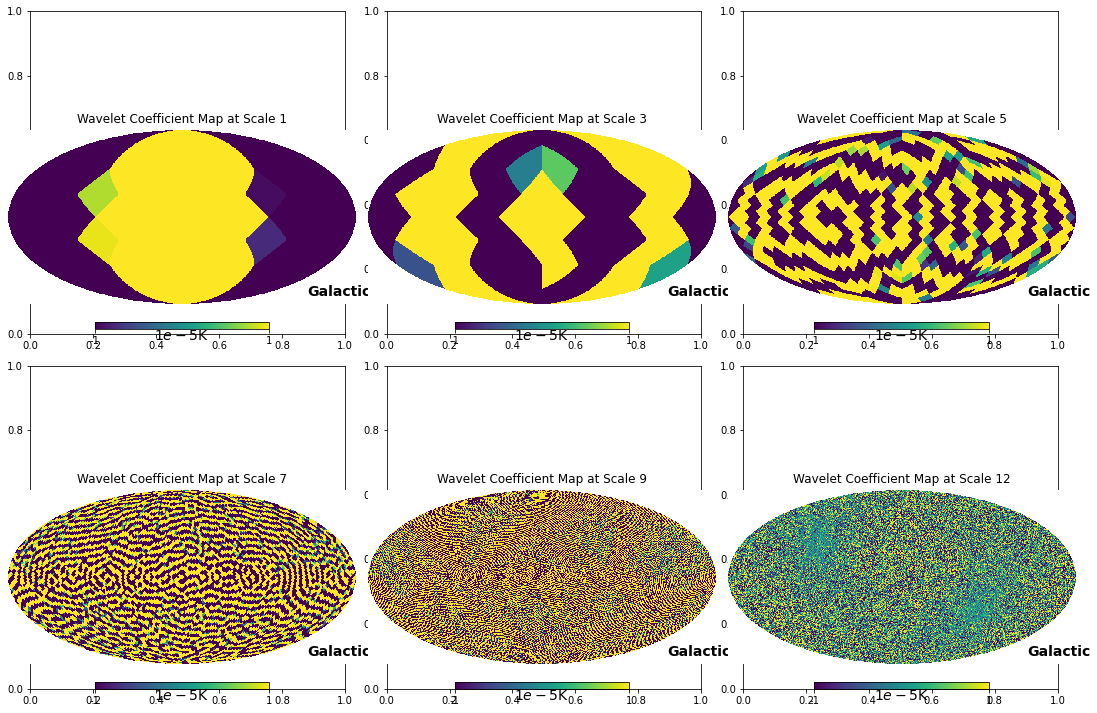

In [17]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Indices of the wavelet scales
indices = [0, 2, 4, 6, 8, 11]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.off

# Loop over the indices and plot each wavelet coefficient map
for idx, i in enumerate(indices):
    wavelet_healpix_map = np.load(f"/home/max/CMB_plot/convolution/wavelet_healpix_map_{i}.npy")
    wavelet_scale = str(i + 1)
    
    hp.mollview(
        wavelet_healpix_map * 1e5,
        coord=["G"],
        title="Wavelet Coefficient Map at Scale " + wavelet_scale,
        unit=r"$1e-5$K",
        min=-1,
        max=1,
        sub=(2, 3, idx + 1),  # Specify the subplot location
        fig=fig,
        
        # ax=axes[idx]
    )
# fig.
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# for i in [0,2,4,6,8,11]:

#     wavelet_healpix_map = np.load(f"/home/max/CMB_plot/convolution/wavelet_healpix_map_{i}.npy") 
#     wavelet_scale = str(i+1)
#     hp.mollview(
#             wavelet_healpix_map*1e5,
#             coord=["G"],
#             title="Wavelet Coefficient Map at Scale "+wavelet_scale,
#             unit=r"$1e-5$K",
#             min=-1, 
#             max=1,
#         )

In [7]:
# Differnt scales of wavelet coefficients

for i in [1,3,5,7,9,11]:

    wavelet_healpix_map = np.load(f"convolution/wavelet_healpix_map_{i}.npy") 
    wavelet_scale = str(i+1)
    hp.mollview(
            wavelet_healpix_map*1e5,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale "+wavelet_scale,
            unit=r"$1e-5$K",
            min=-1, 
            max=1,
        )


FileNotFoundError: [Errno 2] No such file or directory: 'convolution/wavelet_healpix_map_1.npy'